In [2]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics
using AlgebraicPetri
using AlgebraicDynamics.UWDDynam
using LabelledArrays
using OrdinaryDiffEq, DelayDiffEq
using Plots

# Compositional methods of model specification

This notebook develops compositional models in the style of structured multicospans and undirected wiring diagrams. It reproduces the examples in Section 2 of *An Algebraic Framework for Structured Epidemic Modeling*.

## Structured Multicospans of Petri nets
In this section we specify a SVIIvR disease model as the composition of three submodels:
- An SIR model for unvaccinated individuals.
- An SIR model for vaccinated individuals (which we call the VIvR model).
- A cross-exposure model which dictates the interactions between unvaccinated and vaccinated individuals.

This construction follows the figure:

<img width = 80% src="img/sviivr.png">

First we specify the composition pattern which dictates the interactions between the three submodels.
In particular the SIR and VIvR models share the recovered population (R), the SIR and cross-exposure models share the susceptible and infected unvaccinated populations (S, I), and the VIvR and cross-exposure models share the susceptible and infected vaccinated populations (V, Iv).

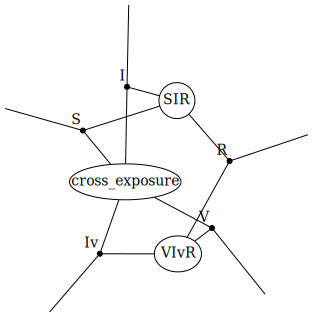

In [3]:
SVIIvR_composition_pattern = @relation (S, V, I, Iv, R) where (S, V, I, Iv, R) begin
  SIR(S, I, R)
  VIvR(V, Iv, R)
  cross_exposure(S, I, V, Iv)
end

to_graphviz(SVIIvR_composition_pattern,
    box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => "1"))

Next we define the Petri nets for the component submodels.

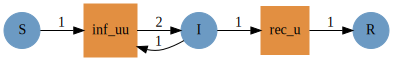

In [4]:
SIR = Open(LabelledPetriNet([:S, :I, :R],
  :inf_uu => ((:S, :I) => (:I, :I)),
  :rec_u => (:I => :R)
))

Graph(SIR)

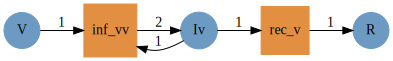

In [5]:
VIvR = Open(LabelledPetriNet([:V, :Iv, :R],
  :inf_vv => ((:V, :Iv) => (:Iv, :Iv)),
  :rec_v => (:Iv => :R)
))

Graph(VIvR)

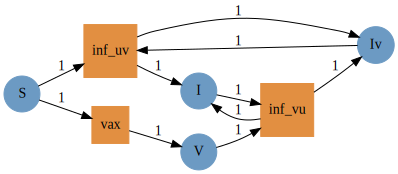

In [6]:
cross_exposure = Open(LabelledPetriNet([:S, :I, :V, :Iv],
  :inf_uv => ((:S, :Iv) => (:I, :Iv)),
  :inf_vu => ((:V, :I) => (:Iv, :I)),
  :vax => (:S => :V)
))

Graph(cross_exposure)

Finally, we compose the component submodels according to the interaction pattern defined by
`SVIIvR_composition_pattern` using the `oapply` method. The result is the SVIIvR model of disease
dynamics which accounts for vaccination.

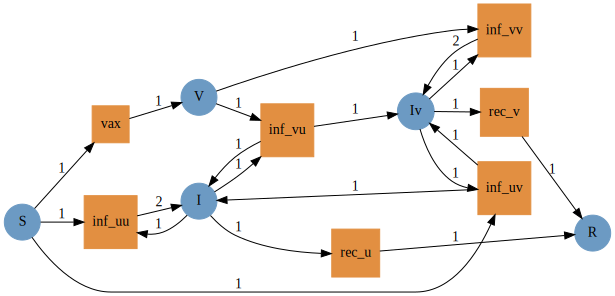

In [7]:
SVIIvR = oapply(SVIIvR_composition_pattern, Dict(
  :SIR => SIR,
  :VIvR => VIvR,
  :cross_exposure => cross_exposure
)) |> apex

Graph(SVIIvR)

We additionally calibrate the parameters of this model with Catalyst.jl in the following: [https://github.com/AlgebraicJulia/Structured-Epidemic-Modeling/tree/main/param_est](https://github.com/AlgebraicJulia/Structured-Epidemic-Modeling/tree/main/param_est).

## Composite disease model for vector borne diseases
In this section, we demonstrate composition of general differential equation models for vector-borne diseases.
This composite has three components: disease dynamics in the host population, disease dynamics in the vector population, and the bloodmeal.

As in the previous example, we begin by specifying the composition pattern which specifies the interaction between the three components.
In particular, the host dynamics and the bloodmeal share the infected host population (Ih), while the vector dynamics and the bloodmeal share the infected vector
population (Iv). We visualize this composition pattern below.
Notice that the disease dynamics in hosts and the disease dynamics in vectors only relate through the bloodmeal.

<img width = 80% src="img/malaria0.png">

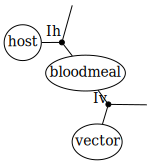

In [8]:
bloodmeal_composition_pattern = @relation (Ih, Iv) where (Ih, Iv) begin
  host(Ih)
  bloodmeal(Ih, Iv)
  vector(Iv)
end

to_graphviz(bloodmeal_composition_pattern,  box_labels = :name, junction_labels = :variable)

Next, we define the component models as ODEs. For each of the disease dynamics in hosts and vectors we specify a single
model which represents the recovery of infected individuals at rates $r$ and $g$ respsectively.

In [9]:
host_dynamics = ContinuousResourceSharer{Float64}(1, 1, (u,p,t) -> -p.r*u, [1]);
vector_dynamics = ContinuousResourceSharer{Float64}(1, 1, (u,p,t) -> -p.g*u, [1]);

For the bloodmeal, we define three model choices for this component. The first bloodmeal model is the law of mass action applied to the Petri net in (b) below. (c) gives the ODE interpretation of the Petri net. 

<img width = 80% src="img/malaria1.png">
<img width = 80% src="img/malaria2.png">

 This model is given by the ODE $$\dot{I}_H = \lambda_H I_V, \quad \dot{I}_V = \lambda_V I_H.$$ So the density of infected hosts grows at a rate $\lambda_H$ proportional to the
density of infected vectors. Likewise, the density of infected vectors grows at a rate $\lambda_V$ proportional to the density of infected hosts.

In [10]:
bloodmeal_mass_action = ContinuousResourceSharer{Float64}(2, 2, (u,p,t) -> [p.λₕ*u[2], p.λₕ*u[1]], [1,2]);

The second bloodmeal model is a Ross-Macdonald model given by the ODE $$\dot{I}_H = \frac{1}{H}ab I_V (H - I_H), \quad \dot{I}_V = ac \frac{I_H}{H}(V - I_V)$$ where $a$ is the biting rate, $b$ is the transmission efficiency from infectious vectors to susceptible
hosts, $c$ is the transmission efficiency from infectious hosts to susceptible vectors, $H$ is the total host population, and $V$ is the total vector population.


<img width = 80% src="img/malaria3.png">

In [11]:
function dudt(u,p,t) 
  Ih, Iv = u
  return [(p.a*p.b/p.H)*Iv*(p.H - Ih), (p.a*p.c)*(Ih/p.H)*(p.V - Iv)]
end
bloodmeal_RossMacdonald = ContinuousResourceSharer{Float64}(2, 2, dudt, [1,2]);

In the third bloodmeal model, we extend the Ross-Macdonald model above by using delay differential equations to represent the incubation period for the disease in the mosquito population.

<img width = 80% src="img/malaria4.png">

In [12]:
function dudt_delay(u,h,p,t)
  Ih, Iv = u
  Ih_delay, Iv_delay = h(p, t - p.n)
  return [(p.a*p.b/p.H)*Iv*(p.H - Ih), (p.a*p.c)*(Ih_delay/p.H)*(p.V - Iv_delay)]
end

bloodmeal_delay = DelayResourceSharer{Float64}(2, 2, dudt_delay, [1,2]);

host_delay   = DelayResourceSharer{Float64}(1, 1, (u,h,p,t) -> -p.r*u, [1]);
vector_delay = DelayResourceSharer{Float64}(1, 1, (u,h,p,t) -> -p.g*u, [1]);

Lastly, we compose the component models according to the composition pattern `bloodmeal_composition_pattern` to specify three composite models for vector-borne disease dynamics.

In [13]:
malaria_mass_action = oapply(bloodmeal_composition_pattern, Dict(
  :host => host_dynamics,
  :vector => vector_dynamics,
  :bloodmeal => bloodmeal_mass_action
));

malaria_RossMacdonald = oapply(bloodmeal_composition_pattern, Dict(
  :host => host_dynamics,
  :vector => vector_dynamics,
  :bloodmeal => bloodmeal_RossMacdonald
));

malaria_delay = oapply(bloodmeal_composition_pattern, Dict(
  :host => host_delay, 
  :vector => vector_delay, 
  :bloodmeal => bloodmeal_delay
));

To illustrate the effect of substituting different choices for the bloodmeal component model, we solve and plot solutions for the composite models.

In [14]:
params = LVector(a = 0.3, b = 0.55, c = 0.15,
    g = 0.1, r = 1.0/200, V = 1000.0, H = 2000.0,
    n = 10.0,
    λₕ = 0., λᵥ = 0.)
params[:λₕ] = params.a * params.b / params.H
params[:λᵥ] = params.a * params.c / params.H

u0 = [10.0, 100.0]
tspan = (0., 365.);

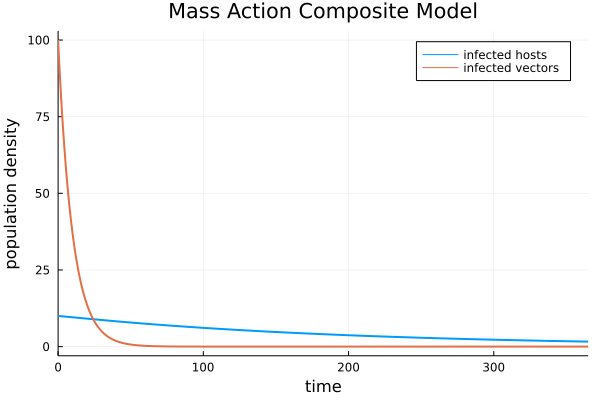

In [15]:
prob = ODEProblem(malaria_mass_action, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol,
  lw = 2,
  label = ["infected hosts" "infected vectors"],
  ylabel = "population density", xlabel = "time", 
  title = "Mass Action Composite Model"
)

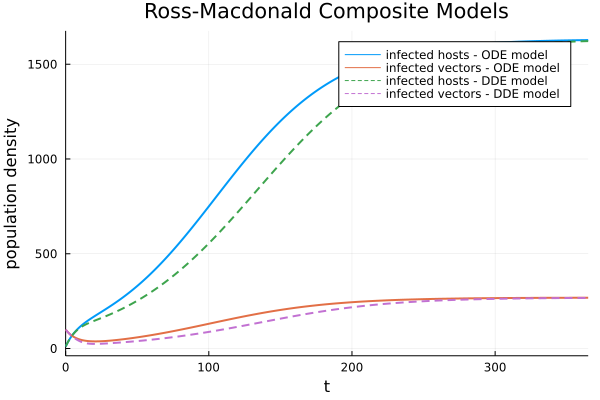

In [16]:
prob_ODE = ODEProblem(malaria_RossMacdonald, u0, tspan, params)
sol_ODE = solve(prob_ODE, Tsit5())

plot(sol_ODE,
  lw = 2,
  label = ["infected hosts - ODE model" "infected vectors - ODE model"],
  ylabel = "population density", xlabel = "time", 
  title = "Ross-Macdonald Composite Models"
)


hist(p, t) = u0
alg = MethodOfSteps(Tsit5())
prob_DDE = DDEProblem(malaria_delay, u0, hist, tspan, params)
sol_DDE = solve(prob_DDE, alg,abstol=1e-12,reltol=1e-12)

plot!(sol_DDE,
  lw = 2,
  linestyle = :dash,
  label = ["infected hosts - DDE model" "infected vectors - DDE model"],
)

The plots demonstrate that the mass action bloodmeal model causes the density of infected hosts and infected vectors to vanish, whereas in the Ross Macdonald models the densities stabilize. These observations suggest that the Ross-Macdonald models are better suited to this modeling problem. On the other hand, the ordinary and delay differential equation Ross-Macdonald models reach the same equilibrium, although they exhibit different transient behavior before settling down.

This structured approach to model composition benefits the modeling workflow by providing tools to rapidly explore  variations on model strucure in order to evaluate the cost-benefit tradeoffs for different models. In this case, we determined that the assumption of mass action is inconsitent with observed phenomena and that the ordinary and delay differential equation Ross-Macdonald models have equivalent  equilibrium behavior. Modelers can thus consider their purpose in studying either transient or equilibrium behavior when deciding if the additional computational requirements of a DDE model are worth the improved fidelity to the transient phenomena. 

This interactive model exploration environment where changes in a model's behavior can be tied back to changes in the model strucure, enables scientists to spend more time on their domain science and less time building, running, and analyzing software systems.